In [1]:
import json
import timeit
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt


## Read files
For county-level data, I am using GADM boundaries that can be downloaded for the entire world [here](https://gadm.org/download_world.html). After downloading them, I took only the level 1 and 2 data and merged them below.

### County-level data (slow)

In [2]:
county_data_path = "../../data/level_2_subdivisions.gpkg"

start = timeit.default_timer()
world_subdivs = gpd.read_file(county_data_path)
end = timeit.default_timer()

print(f"Time to load data: {(end - start):.5f}s")


Time to load data: 59.70357s


In [3]:
world_subdivs


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.1_1,Baharak,NA,NA,Wuleswali,District,NA,AF.BD.BA,"MULTIPOLYGON (((71.41149 36.55717, 71.40954 36..."
1,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.2_1,Darwaz,NA,NA,Wuleswali,District,NA,AF.BD.DA,"MULTIPOLYGON (((71.27620 38.00465, 71.27578 38..."
2,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.3_1,Fayzabad,NA,NA,Wuleswali,District,NA,AF.BD.FA,"MULTIPOLYGON (((70.78272 37.27678, 70.78635 37..."
3,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.4_1,Ishkashim,NA,NA,Wuleswali,District,NA,AF.BD.IK,"MULTIPOLYGON (((71.41149 36.55717, 71.40091 36..."
4,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.5_1,Jurm,NA,NA,Wuleswali,District,NA,AF.BD.JU,"MULTIPOLYGON (((70.71236 37.07621, 70.73582 37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47212,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.10_2,Redcliff,NA,NA,District,District,NA,NA,"MULTIPOLYGON (((29.69907 -19.00888, 29.71847 -..."
47213,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.11_2,Shurugwi,NA,NA,District,District,NA,NA,"MULTIPOLYGON (((29.87560 -20.00570, 29.87369 -..."
47214,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.12_2,Shurugwi Town,NA,NA,District,District,NA,NA,"MULTIPOLYGON (((30.05583 -19.69895, 30.05583 -..."
47215,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.13_2,Zvishavane,NA,NA,District,District,NA,NA,"MULTIPOLYGON (((30.37508 -20.44078, 30.37532 -..."


In [4]:
world_subdivs.columns


Index(['GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')

### State-level data

In [5]:
state_data_path = "../../data/level_1_state_all.gpkg"

start = timeit.default_timer()
world_states = gpd.read_file(state_data_path)
end = timeit.default_timer()

print(f"Time to load data: {(end - start):.5f}s")


Time to load data: 39.28565s


In [6]:
world_states.head()


,GID_0,COUNTRY,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,AFG,Afghanistan,AFG.1_1,Badakhshan,Badahšan,NA,Velayat,Province,NA,AF.BD,NA,"MULTIPOLYGON (((71.11366 35.97130, 71.10155 35..."
1,AFG,Afghanistan,AFG.2_1,Badghis,Badghes|Badghisat|Badgis,NA,Velayat,Province,NA,AF.BG,AF-BDG,"MULTIPOLYGON (((63.76845 34.52948, 63.75823 34..."
2,AFG,Afghanistan,AFG.3_1,Baghlan,Baglan|Bughlan,NA,Velayat,Province,NA,AF.BL,AF-BGL,"MULTIPOLYGON (((68.05261 35.08151, 68.03890 35..."
3,AFG,Afghanistan,AFG.4_1,Balkh,Balh|Mazar-i-Sharif|Mazar,NA,Velayat,Province,NA,AF.BK,AF-BAL,"MULTIPOLYGON (((67.11067 36.00776, 67.14209 35..."
4,AFG,Afghanistan,AFG.5_1,Bamyan,NA,NA,Velayat,Province,NA,AF.BM,AF-BAM,"MULTIPOLYGON (((67.30598 34.38105, 67.32777 34..."


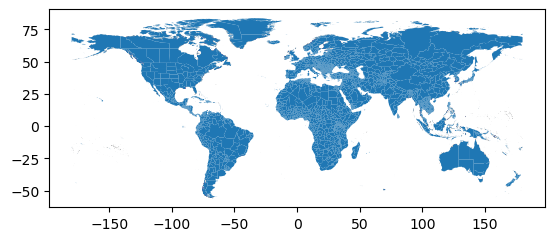

In [8]:
world_states.plot()
plt.show()


[]

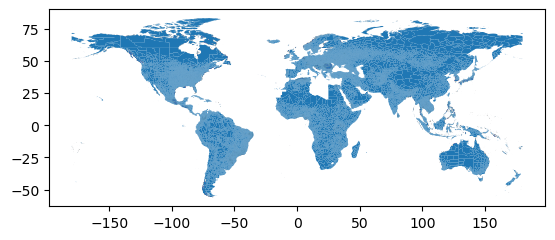

In [7]:
world_subdivs.plot()
plt.plot()


We can see that there are some countries without level 2 geometries. We need to find these countries so that we can replace them with the level 1 geometries as a fill-in.

In [9]:
unique_subdivs = set(world_subdivs.COUNTRY.values)
unique_states = set(world_states.COUNTRY.values)
missing_geometries = sorted(list(unique_states - unique_subdivs))
print(missing_geometries)


['Akrotiri and Dhekelia', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Armenia', 'Bahamas', 'Bahrain', 'Barbados', 'Belize', 'Bermuda', 'Bonaire, Sint Eustatius and Saba', 'British Virgin Islands', 'Cabo Verde', 'Cayman Islands', 'Comoros', 'Cook Islands', 'Cyprus', 'Dominica', 'French Polynesia', 'French Southern Territories', 'Greenland', 'Grenada', 'Guam', 'Guernsey', 'Isle of Man', 'Israel', 'Jamaica', 'Jersey', 'Kuwait', 'Lesotho', 'Libya', 'Liechtenstein', 'Marshall Islands', 'Mauritius', 'Mayotte', 'Moldova', 'Montenegro', 'Montserrat', 'NA', 'Nauru', 'North Macedonia', 'Northern Cyprus', 'Northern Mariana Islands', 'Palau', 'Puerto Rico', 'Qatar', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'San Marino', 'Seychelles', 'Singapore', 'Svalbard and Jan Mayen', 'Tokelau', 'Trinidad and Tobago', 'Turks and Caicos Islands', 'Tuvalu', 'United States Minor Outlying Isl', 'Western Sahara']


In [10]:
missing_subdivs = world_states[world_states.COUNTRY.isin(missing_geometries)]
missing_subdivs


,GID_0,COUNTRY,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
52,AIA,Anguilla,AIA.1_1,Blowing Point,NA,NA,District,District,NA,AI.BP,NA,"MULTIPOLYGON (((-63.07311 18.18212, -63.07696 ..."
53,AIA,Anguilla,AIA.15_1,Dog Island,NA,NA,Island,Island,NA,NA,NA,"MULTIPOLYGON (((-63.25125 18.28389, -63.24369 ..."
54,AIA,Anguilla,AIA.2_1,East End,NA,NA,District,District,NA,AI.EE,NA,"MULTIPOLYGON (((-62.99024 18.24642, -62.98489 ..."
55,AIA,Anguilla,AIA.3_1,George Hill,NA,NA,District,District,NA,AI.GH,NA,"MULTIPOLYGON (((-63.07311 18.18212, -63.07629 ..."
56,AIA,Anguilla,AIA.4_1,Island Harbour,NA,NA,District,District,NA,AI.IH,NA,"MULTIPOLYGON (((-62.98489 18.24553, -62.99024 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3647,ZNC,Northern Cyprus,ZNC.1_1,Gazimağusa,Famagusta|Gazimagusa,Αμμόχωστος,Kaza,District,NA,NA,NA,"MULTIPOLYGON (((33.90652 35.06912, 33.90738 35..."
3648,ZNC,Northern Cyprus,ZNC.2_1,Girne,Kyrenia,Κερύvεια,Kaza,District,NA,NA,NA,"MULTIPOLYGON (((33.66310 35.35939, 33.66003 35..."
3649,ZNC,Northern Cyprus,ZNC.3_1,Güzelyurt,Morphou,NA,Kaza,District,NA,NA,NA,"MULTIPOLYGON (((33.12013 35.16034, 33.10912 35..."
3650,ZNC,Northern Cyprus,ZNC.4_1,Iskele,Trikomo,NA,Kaza,District,NA,NA,NA,"MULTIPOLYGON (((33.90078 35.23314, 33.85364 35..."


[]

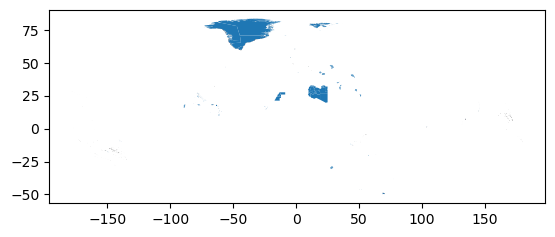

In [11]:
missing_subdivs.plot()
plt.plot()


In [12]:
print(list(world_states.columns))


['GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry']


In [13]:
print(list(world_subdivs.columns))


['GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2', 'geometry']


One problem: the subdivisions has a `GID_2` column, whereas the states data only has a `GID_1` column. So we will still want to copy that information over because we need to access the `GID_2` column for plotting.


In [14]:
missing_subdivs["GID_2"] = missing_subdivs["GID_1"]
print(list(missing_subdivs.columns))


['GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry', 'GID_2']


/Users/jdriscol/miniconda3/envs/shiny_geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
merged = pd.concat([world_subdivs, missing_subdivs])
merged.head()


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
0,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.1_1,Baharak,NA,NA,Wuleswali,District,NA,AF.BD.BA,"MULTIPOLYGON (((71.41149 36.55717, 71.40954 36...",NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.2_1,Darwaz,NA,NA,Wuleswali,District,NA,AF.BD.DA,"MULTIPOLYGON (((71.27620 38.00465, 71.27578 38...",NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.3_1,Fayzabad,NA,NA,Wuleswali,District,NA,AF.BD.FA,"MULTIPOLYGON (((70.78272 37.27678, 70.78635 37...",NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.4_1,Ishkashim,NA,NA,Wuleswali,District,NA,AF.BD.IK,"MULTIPOLYGON (((71.41149 36.55717, 71.40091 36...",NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.5_1,Jurm,NA,NA,Wuleswali,District,NA,AF.BD.JU,"MULTIPOLYGON (((70.71236 37.07621, 70.73582 37...",NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print(np.sum(merged.GID_1.isnull()))
print(np.sum(merged.GID_2.isnull()))


0
0


[]

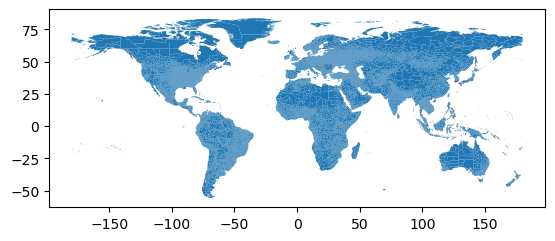

In [17]:
merged.plot()
plt.plot()


The next problem: these geometries include water bodies, which we don't want to include for plotting purposes. We need to find where geometries are water bodies and drop them from our dataframe.

In [18]:
# some values are None or nan, which we don't need to look at
unique_types = sorted([use_type for use_type in merged.ENGTYPE_2.unique() if type(use_type) is str])
print(unique_types)


['Aboriginal Council', 'Administrative Area', 'Administrative County', 'Administrative Zone', 'Area', 'Area Outside Territorial Authori', 'Area council', 'Arrondissement', 'Assembly', 'Atol', 'Autonomous City', 'Autonomous Okurg', 'Autonomous Prefecture', 'Autonomous district', 'Borough', 'Borough District', 'Canton', 'Capital', 'Capital Region', 'Census Area', 'Census Division', 'Chef-Lieu-Wilaya', 'Circle', 'City', 'City Council', 'City Municipality', 'City and Borough', 'City and County', 'City council', 'City of Regional Significance', 'City with powiat rights', 'Commune', 'Commune-Cotiere', 'Commune|Municipality', 'Conservancy', 'Constituency', 'Corregimiento Departamental', 'County', 'Delegation', 'Department', 'Dependency', 'Distict', 'District', 'District Council', 'District Municipality', 'Districts|Municipals', 'Distrito Metropolitano', 'Division', 'Emirate', 'Federal District', 'Federal Territory', 'Governorate', 'Headquarter', 'Independent City', 'Indigenous Territory', 'Is

In [19]:
water_uses = [use_type for use_type in unique_types if "water" in use_type.lower()]
water_uses


['Water Body', 'Water body', 'Waterbody']

So we really have one use type to look at, but it is stored in the dataframe as 3 separate values.

In [20]:
merged[merged.ENGTYPE_2.isin(water_uses)]


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
2009,BDI,Burundi,BDI.2_1,Bujumbura Mairie,NA,BDI.2.10_1,Lake Tanganyika,NA,NA,Water body,Water body,NA,NA,"MULTIPOLYGON (((29.30763 -3.34949, 29.30870 -3...",NaN,NaN,NaN,NaN,NaN,NaN
2018,BDI,Burundi,BDI.3_1,Bujumbura Rural,NA,BDI.3.5_1,Lake Tanganyika,NA,NA,Water body,Water body,NA,NA,"MULTIPOLYGON (((29.34576 -3.43441, 29.34546 -3...",NaN,NaN,NaN,NaN,NaN,NaN
2029,BDI,Burundi,BDI.4_1,Bururi,NA,BDI.4.4_1,Lake Tanganyika,NA,NA,Water body,Water body,NA,NA,"MULTIPOLYGON (((29.31201 -3.73095, 29.31205 -3...",NaN,NaN,NaN,NaN,NaN,NaN
2083,BDI,Burundi,BDI.11_1,Makamba,NA,BDI.11.3_1,Lake Tanganyika,NA,NA,Water body,Water body,NA,NA,"MULTIPOLYGON (((29.37993 -4.18781, 29.42145 -4...",NaN,NaN,NaN,NaN,NaN,NaN
8915,CAN,Canada,CAN.9_1,Ontario,NA,CAN.9.21_1,Lake Erie,NA,NA,Water body,Water body,NA,CA.ON.WB,"MULTIPOLYGON (((-82.46629 42.04435, -82.46431 ...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44198,USA,United States,USA.36_1,Ohio,NA,USA.36.44_1,Lake Erie,NA,NA,Water body,Water body,NA,US.OH.WB,"MULTIPOLYGON (((-83.13252 42.17415, -83.13320 ...",NaN,NaN,NaN,NaN,NaN,NaN
45193,USA,United States,USA.50_1,Wisconsin,NA,USA.50.34_1,Lake Michigan,NA,NA,Water body,Water body,NA,US.WI.WB,"MULTIPOLYGON (((-87.01808 42.49470, -87.79801 ...",NaN,NaN,NaN,NaN,NaN,NaN
45194,USA,United States,USA.50_1,Wisconsin,NA,USA.50.35_1,Lake Superior,NA,NA,Water body,Water body,NA,US.WI.WB,"MULTIPOLYGON (((-89.95798 47.29118, -90.39261 ...",NaN,NaN,NaN,NaN,NaN,NaN
45329,UZB,Uzbekistan,UZB.5_1,Qaraqalpaqstan,NA,UZB.5.2_1,Aral Sea,NA,NA,Waterbody,Waterbody,NA,NA,"MULTIPOLYGON (((58.57805 45.56678, 58.63279 45...",NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# now let's remove those rows
merged = merged[~merged.ENGTYPE_2.isin(water_uses)]
merged.head()


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
0,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.1_1,Baharak,NA,NA,Wuleswali,District,NA,AF.BD.BA,"MULTIPOLYGON (((71.41149 36.55717, 71.40954 36...",NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.2_1,Darwaz,NA,NA,Wuleswali,District,NA,AF.BD.DA,"MULTIPOLYGON (((71.27620 38.00465, 71.27578 38...",NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.3_1,Fayzabad,NA,NA,Wuleswali,District,NA,AF.BD.FA,"MULTIPOLYGON (((70.78272 37.27678, 70.78635 37...",NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.4_1,Ishkashim,NA,NA,Wuleswali,District,NA,AF.BD.IK,"MULTIPOLYGON (((71.41149 36.55717, 71.40091 36...",NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.5_1,Jurm,NA,NA,Wuleswali,District,NA,AF.BD.JU,"MULTIPOLYGON (((70.71236 37.07621, 70.73582 37...",NaN,NaN,NaN,NaN,NaN,NaN


Next problem: some countries have states that are too small to be processed by our raster-burn method without downscaling the data.

In [22]:
small_polygons = merged[merged.geometry.area < 0.02]
small_polygons


/var/folders/kb/xrktft5d0jq3b8170ldjhkn00000gp/T/ipykernel_29664/680525716.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  small_polygons = merged[merged.geometry.area < 0.02]


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
42,AFG,Afghanistan,AFG.4_1,Balkh,NA,AFG.4.11_1,Mazar-i-Sharif,NA,NA,Wuleswali,District,NA,AF.BK.MS,"MULTIPOLYGON (((67.07002 36.67928, 67.07163 36...",NaN,NaN,NaN,NaN,NaN,NaN
119,AFG,Afghanistan,AFG.12_1,Hirat,NA,AFG.12.7_1,Hirat City,Hirat,NA,Wuleswali,District,NA,AF.HR.HI,"MULTIPOLYGON (((62.21255 34.35409, 62.20830 34...",NaN,NaN,NaN,NaN,NaN,NaN
141,AFG,Afghanistan,AFG.14_1,Kabul,NA,AFG.14.4_1,Gul dara,NA,NA,Wuleswali,District,NA,AF.KB.GD,"MULTIPOLYGON (((68.92336 34.85382, 68.93452 34...",NaN,NaN,NaN,NaN,NaN,NaN
142,AFG,Afghanistan,AFG.14_1,Kabul,NA,AFG.14.5_1,Istalif,NA,NA,Wuleswali,District,NA,AF.KB.IS,"MULTIPOLYGON (((69.12677 34.81754, 69.11417 34...",NaN,NaN,NaN,NaN,NaN,NaN
144,AFG,Afghanistan,AFG.14_1,Kabul,NA,AFG.14.7_1,Kalakan,NA,NA,Wuleswali,District,NA,AF.KB.KL,"MULTIPOLYGON (((69.23820 34.78852, 69.23452 34...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3509,VGB,British Virgin Islands,VGB.3_1,Other Islands,NA,VGB.3_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-64.60403 18.32403, -64.60291 ...",NA,District,District,NA,NA,NA
3510,VGB,British Virgin Islands,VGB.4_1,Tortola,NA,VGB.4_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-64.71152 18.38181, -64.71125 ...",NA,District,District,NA,NA,NA
3511,VGB,British Virgin Islands,VGB.5_1,Virgin Gorda,NA,VGB.5_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-64.45514 18.39931, -64.45514 ...",NA,District,District,NA,NA,NA
3598,XAD,Akrotiri and Dhekelia,XAD.1_1,Akrotiri,NA,XAD.1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((32.99073 34.63443, 33.00867 34...",Western Sovereign Base Area,Sovereign Base Area,Sovereign Base Area,NA,NA,NA


In [23]:
len(np.unique(small_polygons.COUNTRY))


195

In [24]:
np.unique(small_polygons.COUNTRY)


array(['Afghanistan', 'Akrotiri and Dhekelia', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antigua and Barbuda', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Bahamas', 'Bahrain', 'Barbados', 'Belgium', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire, Sint Eustatius and Saba',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei',
       'Bulgaria', 'Burundi', 'Cabo Verde', 'Cambodia', 'Canada',
       'Cayman Islands', 'Central African Republic', 'Chile', 'China',
       'Colombia', 'Comoros', 'Cook Islands', 'Costa Rica', 'Croatia',
       'Cuba', 'Czechia', 'Democratic Republic of the Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faroe Islands', 'Fiji', 'France', 'French Guiana',
       'French Southern Territories', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Grenada', 'Gua

In [25]:
np.unique([str(value) for value in merged.ENGTYPE_1])


array(['Administrative subdivisions', 'Atol', 'Atoll',
       'Autonomous Island', 'Autonomous Territory', 'Autonomous island',
       'Borough', 'City', 'Commune', 'County', 'Dependency', 'District',
       'Governorate', 'Island', 'Island Council', 'Municipality', 'NA',
       'National Park', 'Outer Islands', 'Parish', 'Parish District',
       'Province', 'Quarter', 'Reef', 'Region', 'Sovereign Base Area',
       'State', 'Territorial Unit', 'Territory', 'Town Council',
       'Town District', 'Village District', 'Water body', 'nan'],
      dtype='<U27')

In [26]:
examine_list = [
    'Atol', 'Atoll', 'Autonomous Island', 'Autonomous Territory', 
    'Autonomous island', "Dependency", 'Governorate', 'Island', 'Island Council', 'NA',
    'Outer Islands', 'Reef', 'Region', 'Sovereign Base Area', 'Territorial Unit', 'Territory', 
               ]

np.unique(merged[merged.ENGTYPE_1.isin(examine_list)].COUNTRY)


array(['Akrotiri and Dhekelia', 'Anguilla', 'Antigua and Barbuda',
       'Bahrain', 'Comoros', 'Cook Islands', 'Grenada',
       'Marshall Islands', 'Mauritius', 'Moldova', 'NA', 'Seychelles',
       'Singapore', 'Svalbard and Jan Mayen', 'Tokelau',
       'Trinidad and Tobago', 'Tuvalu',
       'United States Minor Outlying Isl'], dtype=object)

In [27]:
np.unique([str(value) for value in merged.ENGTYPE_2])


array(['Aboriginal Council', 'Administrative Area',
       'Administrative County', 'Administrative Zone', 'Area',
       'Area Outside Territorial Authori', 'Area council',
       'Arrondissement', 'Assembly', 'Atol', 'Autonomous City',
       'Autonomous Okurg', 'Autonomous Prefecture', 'Autonomous district',
       'Borough', 'Borough District', 'Canton', 'Capital',
       'Capital Region', 'Census Area', 'Census Division',
       'Chef-Lieu-Wilaya', 'Circle', 'City', 'City Council',
       'City Municipality', 'City and Borough', 'City and County',
       'City council', 'City of Regional Significance',
       'City with powiat rights', 'Commune', 'Commune-Cotiere',
       'Commune|Municipality', 'Conservancy', 'Constituency',
       'Corregimiento Departamental', 'County', 'Delegation',
       'Department', 'Dependency', 'Distict', 'District',
       'District Council', 'District Municipality',
       'Districts|Municipals', 'Distrito Metropolitano', 'Division',
       'Emirate', 

We are going to have to simplify the geometry, because the GADM data is fairly high-resolution. Even with the raster-burn method, this still makes the polygons slow to load on a web map.


In [28]:
world = merged.copy()
world["geometry"] = world["geometry"].simplify(0.001).buffer(0)


In [30]:
# world.to_file('../../data/level_1_2_merged.gpkg', driver='GPKG', layer='gadm_layer_1_2_merged')  
